In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils.speedup import calculate_speedups
sns.set_theme()

## Read data

In [2]:
threads = 32

branches = ['split-counters',
            'split-counters-cache-padded',
            'split-counters-sleepers-only-cache-padded',
            'split-counters-no-jec',
            'split-counters-no-jec-cache-padded',
            'split-counters-no-jec-sleepers-only',
            'split-counters-no-jec-sleepers-only-cache-padded']

our_df = None
master_df = None

for i in range(1, threads + 1):
    for branch in branches:
        filename = '12-07-2022/speedup-{}-{}-threads.csv'.format(branch, i)
        new_df = pd.read_csv(filename)
        new_df['threads'] = i
        new_df['branch'] = branch
        our_df = pd.concat([our_df, new_df], ignore_index = True)
        
    filename = '12-07-2022/speedup-master-{}-threads.csv'.format(i)
    new_master_df = pd.read_csv(filename)
    new_master_df['threads'] = i
    new_master_df['branch'] = 'master'
    master_df = pd.concat([master_df, new_master_df], ignore_index = True)

## Calculate speedups and prepare to plot

In [3]:
speedups_us = calculate_speedups(our_df)
speedups_us_df = pd.DataFrame(data=speedups_us)

speedups_master = calculate_speedups(master_df)
speedups_master_df = pd.DataFrame(data=speedups_master)

df = pd.concat([speedups_us_df, speedups_master_df], ignore_index = True)

## Plot fixed frequency speedups

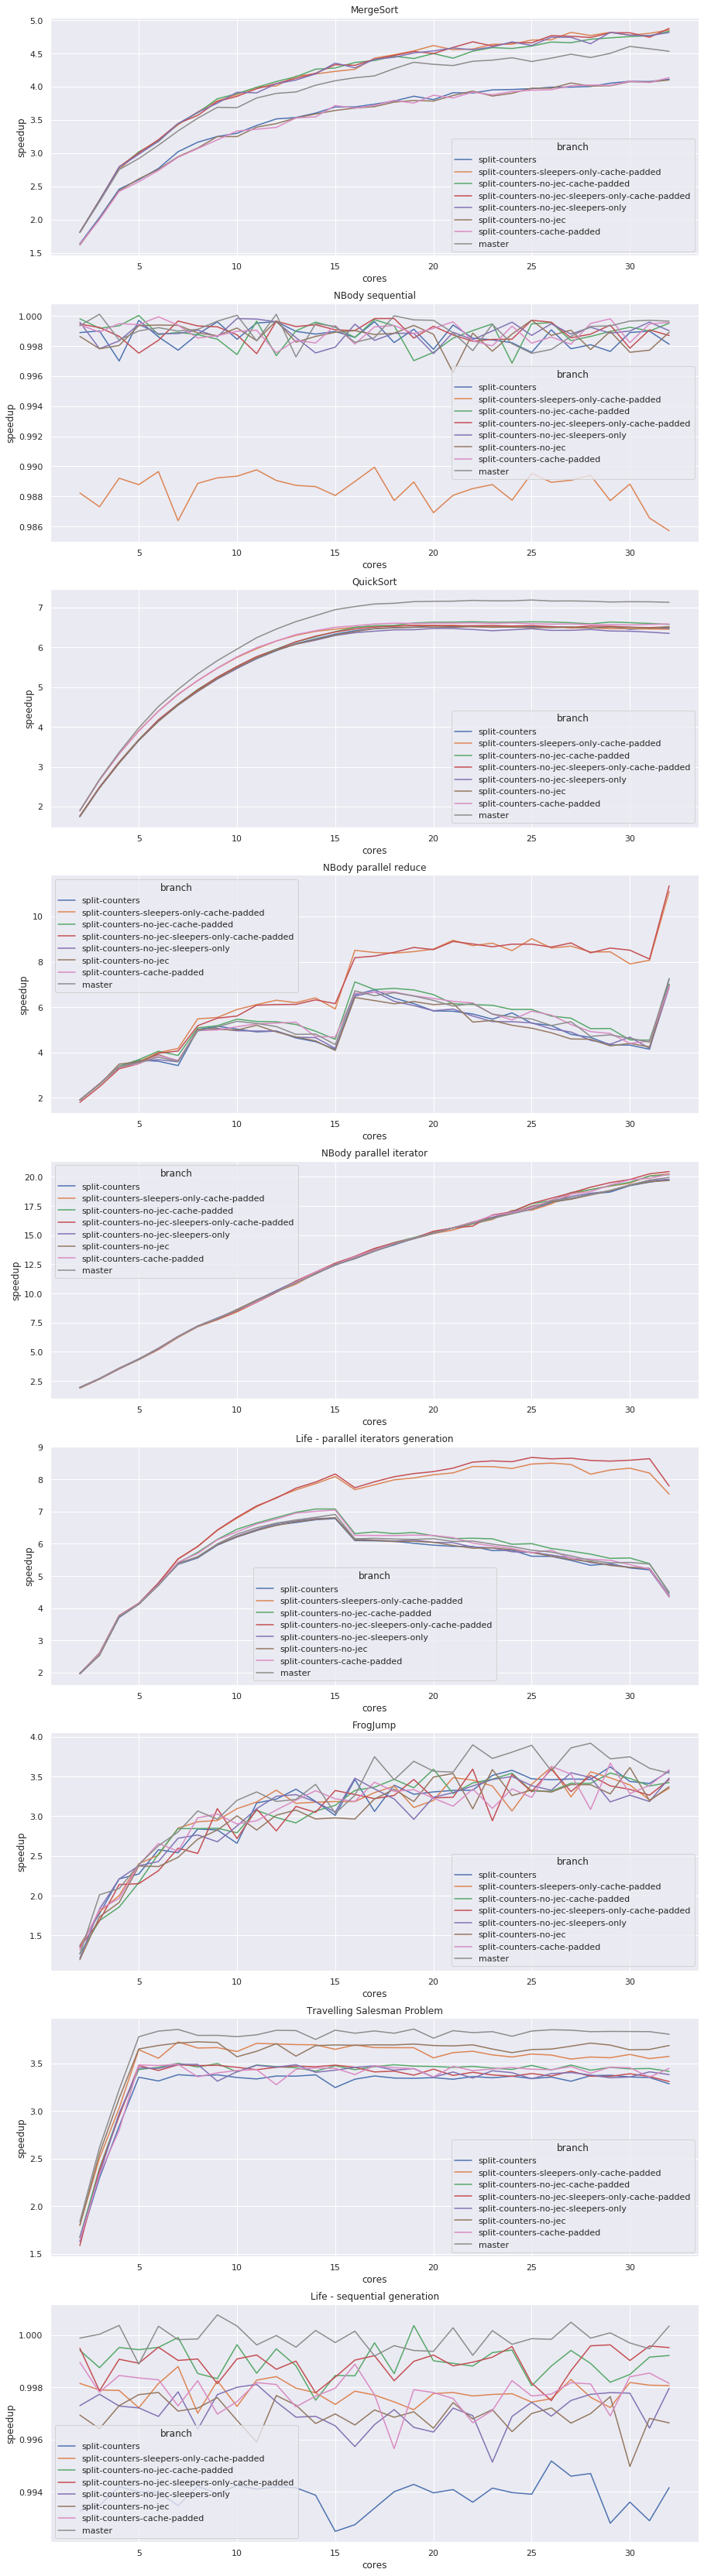

In [4]:
algorithms = set(df['name'])

fig, axs = plt.subplots(len(algorithms), figsize=(15, 60))

for i, algorithm in enumerate(algorithms):
    algorithm_df = df[df['name'] == algorithm]
    
    sns.lineplot(x='cores', y='speedup', hue='branch', data=algorithm_df, ax=axs[i]);
    axs[i].set_title(algorithm);    

## Branches

### master

Master branch of rayon without changes.

### split-counters

This branch uses one word for each atomic counter instead of packing all of them in a single word. There are three atomic counters: inactive threads, sleeping threads and the jobs event counter.

### split-counters-no-jec

Build on top of `split-counters`, this branch still uses three separeted counters, but remove the JEC mechanism.

### split-counters-no-jec-sleepers-only

Counters still split. When new jobs are posted, the default behavior of master is to use the number of inactive threads and the number of active threads to decide how many threads to wakeup. When the counters were packed, this could be done using only one load. After the counters were split, two loads were necessary in order to have the updated values of `sleeping_threads` and `inactive_threads`. Since the number of inactive threads was only used to an heuristic that doesn't look helpful, this branch removes the load and usage of `inactive_threads` and uses only the number of sleeping threads and the number of jobs to decide how many threads to wake up. 

### split-counters-sleepers-only-cache-padded

Still uses the Job Events Counter mechanism, but don't load the inactive threads counter to decide how many threads to wake up when a new job is posted. There are a lot of writes to this counter, which should cause cache missses.

## Conclusion

As seen on the [last experiment](notebooks/experiments/speedup/speedup-split-atomic-counters.ipynb), splitting the counters without cache-padding them hadn't shown significant performance improvements. Thus, we decided to perform another batch of experiments padding them. 

Only splitting the counters doesn't give us performance improvements directly. That can be seen when we compare the master branch with `split-counters-cache-padded`. The results are almost the same, except for the QuickSort, that weirdly performs a bit better on `master`.

As we have seen in the past experiments, the atomic counters are responsible for a bottleneck on performance caused when the number of threads increases significantly. Splitting the counters allowed us to identify exactly which counter exactly was causing the problem.

At first, we thought that the jobs event counter could be causing the problem: if threads become sleepy often, the counter is written to a lot, delaying the loads. If we compare the branches `master` and `split-counters-no-jec-cache-padded`, we can see small improvements or no changes at all on performance, depending on the algorithm. This seems reasonable, since (to be verified):
    - An algorithm where threads don't reach the sleepy state too often won't benefit from removing the mechanism, since they don't write to the counter frequently.
    - An algorithm where threads reach the sleepy state often on master, would show a performance improvement when the JEC mechanism is removed, since on master they were writes to an atomic counter that was now removed.

As we mention in the last experiment, the `master` branch of rayon uses the number of sleeping threads and the number of inactive threads to decide how many threads to wake up when a new job is posted. The counter of inactive threads is written a lot to, as this number changes whenever a worker start looking for jobs and when a worker found a job. Our second hyphothesis for the bottleneck was this counter. Since we have splitted the counters, it was possible to remove the load of the inactive threads counter and use only the number of sleeping threads to decide how many threads to wake up. When we compare the branches `master` and `split-counters-sleepers-only-cache-padded`, it's possible to see a significant improvement on performance for almost all algorithms when we stop reading the inactive threads counter whenever a new job is posted. Weirdly again, QuickSort and TSP still performs a little better on master. I believe this means that the heuristic to decide the number of threads to wake up may help this algorithms. The heuristic was:

```Rust
// If the queue is non-empty, then we always wake up a worker
// -- clearly the existing idle jobs aren't enough. Otherwise,
// check to see if we have enough idle workers.
if !queue_was_empty {
    let num_to_wake = std::cmp::min(num_jobs, num_sleepers);
    self.wake_any_threads(num_to_wake);
} else if num_awake_but_idle < num_jobs {
    let num_to_wake = std::cmp::min(num_jobs - num_awake_but_idle, num_sleepers);
    self.wake_any_threads(num_to_wake);
}
```

The number of inactive threads it used to calculate `num_awake_but_idle`, which is `sleeping_threads` minus `inactive_threads`. I'm not sure about that, but for me, the only reason why QuickSort and TSP could perform better on master is:

**1)** Lots of new jobs are posted when the queue is already empty.  
**2)** `master` will wakeup only the necessary number of workers, which is the number of jobs minus the number of workers currently working.  
**3)** `split-counters-sleepers-only-cache-padded` wakes up exactly the number of jobs, which may be more than necessary, since the active workers will finish their jobs and be available to help the others.  
**4)** The first workers will find something to do, and the others will become idle. Those who become idle will eventually become sleepy (causing a write to the jobs event counter), and later, they'll go to sleep and write to the sleeping threads counter.  
**5)** The sleeping threads counter and the jobs event counter are loaded whenever a new job is posted. Unnecessary writes to them made by item **4)** will delay the loads when `new_jobs` is called.

To sum up, this experiment showed us that stop loading the inactive threads counter to decide how many threads to wakeup improves significantly performance considering a scenario where the three counters are atomic and not packed in a single word. The tests were performed on a fixed-frequency scenario and the speedup curves were traced using the number of cores as the limit for parallelism (there is no multithreading). However, the CPUFreq governor shouldn't interfere on that. The effects of multithreading are unknown for me at this moment. We can easly re-run these experiments on a dynamic frequency scenario and using 64 threads instead of 32. 